In [88]:
import wandb
import torch
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from torch.utils.data import Dataset, DataLoader
import glob
import cv2 as cv
import segmentation_models_pytorch as smp
from tqdm import tqdm
from torchvision import transforms as T
import numpy as np

## Logging Infrastructure

In [89]:
wandb.login()
%env "WANDB_NOTEBOOK_NAME" "UNet.ipynb"

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


env: "WANDB_NOTEBOOK_NAME"="UNet.ipynb"


In [90]:
class WAndBConfig:
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    LEARNING_RATE = 1e-3
    N_EPOCHS = 20
    LOSS_FUNCTION = "torch.nn.CrossEntropyLoss"

WANDB_CONFIG = {'_wandb_kernel': 'neuracort'}

logger_run = wandb.init(
    project='LiTS_UNet_e1',
    config = WANDB_CONFIG
)

## LiTS Dataset & DataLoader

In [91]:
imagenet_mean = np.mean(np.array([0.485, 0.456, 0.406]))
imagenet_std = np.mean(np.array([0.229, 0.224, 0.225]))

def get_transforms():
    return T.Compose([
        T.ToTensor(),
        T.Normalize(
            [imagenet_mean],
            [imagenet_std]
        )
    ])

In [92]:
class LiTSDataset(Dataset):
    """
    Summary:
    ----
    Dataset class to retrieve samples from the the LiTS dataset one sample at the time
    """

    def __init__(self, rootDataDirectory:str, datasetSplit:str) -> None:
        """
        Summary:
        ----
        Prepare access to dataset

        Args:
        ----
            * rootDataDirectory (str): Path to the root directory of the dataset
            * datasetSplit (_type_): Type of split to use from the available data. Available options are "train", (add more options)
        """
        # Initialize class members from constructor arguments
        self.root_data_directory = rootDataDirectory
        self.split = datasetSplit
        
        # Initialize additional class memebers
        samples_directory_name = "images"
        annotations_directory_name = "labels"
        self.samples_paths = glob.glob(self.root_data_directory + self.split + "/" + samples_directory_name + "/liver*/*.bmp")
        self.annotations_paths = glob.glob(self.root_data_directory + self.split + "/" + annotations_directory_name + "/liver*/*.bmp")
        
        self.samples_count = len(self.samples_paths)
        self.annotations_count = len(self.annotations_paths)
        
        if self.samples_count != self.annotations_count:
            raise ValueError("Different number of files in the samples and annotations directories.")

    def __len__(self) -> int:
        """
        Summary:
        ----
        Return dataset size

        Returns:
        ----
            * int: Number of available samples in the dataset. Consider the dataset to have an identical number of annotations
        """
        return self.samples_count
    
    def __getitem__(self, index) -> 'tuple[torch.Tensor, torch.Tensor]':
        """
        Summary:
        ----
            Return a sample and its corresponding annotation from the dataset

        Args:
        ----
            * index (int): Index of the sample to access from the dataset
        
        Raises:
        ----
            * IndexError: Error if passed index is smaller than 0 or bigger than the maximum available number of samples

        Returns:
        ----
            * tuple[torch.Tensor, torch.Tensor]: Tuple containing a dataset sample and its corresponding annotation
        """

        # Check if the index lies within a valid range
        if index < 0 or index > self.samples_count - 1:
            raise IndexError(f"Cannot access sample with index {index} because it is outside of the [0, {self.samples_count}) interval.")

        # Read and return sample and annotation from index
        sample_path = self.samples_paths[index]
        annotation_path = self.annotations_paths[index]

        raw_sample = cv.imread(sample_path, cv.IMREAD_UNCHANGED)
        raw_annotation = cv.imread(annotation_path, cv.IMREAD_UNCHANGED)

        return raw_sample, raw_annotation
    
    def collate_fn(self, batch):
        images, masks = list(zip(*batch))

        images = torch.cat([get_transforms()(image.copy()/255.)[None] for image in images]).float().to(WAndBConfig.DEVICE)
        masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(WAndBConfig.DEVICE)

        return images, masks

    def get_sample_and_annotation_paths(self, index):
        # Check if the index lies within a valid range
        if index < 0 or index > self.samples_count - 1:
            raise IndexError(f"Cannot access sample with index {index} because it is outside of the [0, {self.samples_count}) interval.")

        # Read and return sample and annotation from index
        sample_path = self.samples_paths[index]
        annotation_path = self.annotations_paths[index]
        
        return sample_path, annotation_path

In [93]:
train_dataset = LiTSDataset(
    rootDataDirectory="../data/",
    datasetSplit="train"
)

validation_dataset = LiTSDataset(
    rootDataDirectory="../data/",
    datasetSplit="validation"
)

test_dataset = LiTSDataset(
    rootDataDirectory="../data/",
    datasetSplit="test"
)

In [107]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=train_dataset.collate_fn
)

validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=validation_dataset.collate_fn
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=test_dataset.collate_fn
)

torch.Size([8, 1, 512, 512])
torch.Size([8, 512, 512])


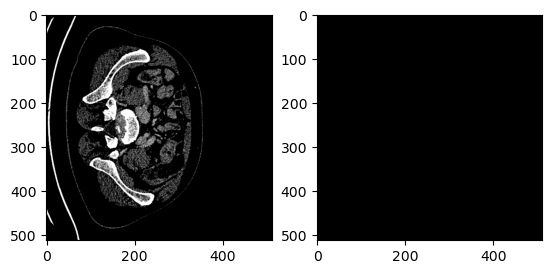

In [101]:
train_samples, train_annotations = next(iter(train_dataloader))

print(train_samples.shape)
print(train_annotations.shape)

fig, axs = plt.subplots(1, 2)

axs[0].imshow(train_samples[3, 0].cpu(), cmap="gray")
axs[1].imshow(train_annotations[3].cpu(), cmap="gray")

## Create & Train U-Net

### Define Loss function

In [103]:
loss = torch.nn.CrossEntropyLoss()

def UNetLoss(predictions, targets):
    batch_loss = loss(predictions, targets)
    batch_accuracy = (torch.max(predictions, 1)[1] == targets).float().mean()
    return batch_loss, batch_accuracy

In [104]:
class engine():
    def train_batch(model, data, optimizer, criterion):
        model.train()

        images, annotations = data
        predictions = model(images)
        optimizer.zero_grad()

        loss, accuracy = criterion(predictions, annotations)
        loss.backward()
        optimizer.step()

        return loss.item(), accuracy.item()

    @torch.no_grad()
    def validate_bacth(model, data, criterion):
        model.eval()

        images, annotations = data
        predictions = model(images)

        loss, accuracy = criterion(predictions, annotations)

        return loss.item(), accuracy.item()

### Define Model 

In [105]:
def make_model():
    model = smp.Unet(
        encoder_name="resnet34",
        encoder_depth=5,
        encoder_weights="imagenet",
        decoder_use_batchnorm=True,
        decoder_channels=[256, 128, 64, 32, 16],
        decoder_attention_type=None,
        in_channels=1,
        classes=3,
        activation=None,
        aux_params=None
    )
    model.to(WAndBConfig.DEVICE)
    criterion = UNetLoss
    optimizer = torch.optim.Adam(model.parameters(), lr=WAndBConfig.LEARNING_RATE)

    return model, criterion, optimizer


### Train Model

In [108]:
model, criterion, optimizer = make_model()

for epoch in range(WAndBConfig.N_EPOCHS):
    print("##"*20)
    print(f"                Epoch: {epoch}          ")

    for _, data in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        train_loss, train_accuracy = engine.train_batch(model, data, optimizer, criterion)
    
    for _, data in tqdm(enumerate(validation_dataloader), total = len(validation_dataloader)):
        validation_loss, validation_acccuracy = engine.validate_bacth(model, data, criterion)

    wandb.log(
          {   
              'epoch': epoch,
              'train_loss': train_loss,
              'train_acc': train_accuracy,
              'val_loss': validation_loss,
              'val_acc': validation_acccuracy
          }
      )

    
    print("##"*20, "\n")

########################################
                Epoch: 0          


100%|██████████| 8379/8379 [01:21<00:00, 103.13it/s]


######################################## 

########################################
                Epoch: 1          


100%|██████████| 8379/8379 [01:20<00:00, 103.58it/s]


######################################## 

########################################
                Epoch: 2          


100%|██████████| 8379/8379 [01:19<00:00, 104.87it/s]


######################################## 

########################################
                Epoch: 3          


100%|██████████| 8379/8379 [01:20<00:00, 104.49it/s]


######################################## 

########################################
                Epoch: 4          


 29%|██▉       | 1546/5293 [03:26<08:19,  7.51it/s]

In [ ]:
torch.save(model.state_dict, "model.pth")